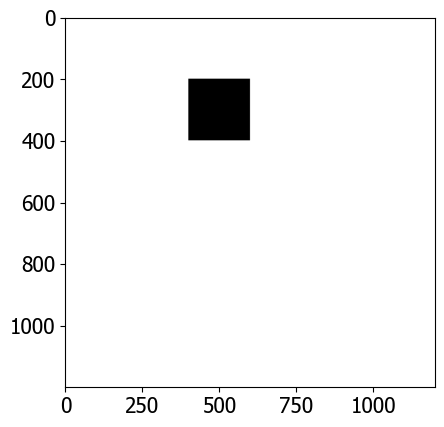

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def create_map(width, height, obstacles=[]):
    # Create a white background
    map_array = np.ones((height, width), dtype=np.uint8) * 255
    
    # Add black obstacles
    for obstacle in obstacles:
        x, y, obstacle_width, obstacle_height = obstacle
        map_array[y:y + obstacle_height, x:x + obstacle_width] = 0

    return map_array

def save_map_to_npy(map_array, file_path):
    np.save(file_path, map_array)

def visualize_map(map_array):
    plt.imshow(map_array, cmap='gray')
    plt.show()

# Example usage:
map_width = 1200
map_height = 1200

# Initial obstacle positions and sizes
obstacles = [(400, 200, 200 , 200)]

# Create and save the map
map_array = create_map(map_width, map_height, obstacles)
#save_map_to_npy(map_array, 'Downloads/map_with_obstacles.npy')

# Visualize the map
visualize_map(map_array)


Total number of pixels: 16384
128 128
(128, 128)


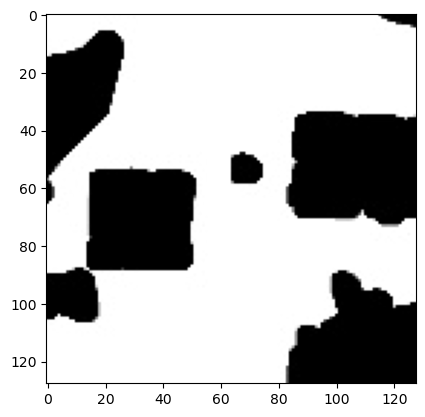

In [10]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread(r"C:\Users\Navdeep\Downloads\0.jpg")

gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


height, width= gray_image.shape

total_pixels = height * width

print("Total number of pixels:", total_pixels)
print(height , width)
print(gray_image.shape)

plt.imshow(gray_image , cmap = 'gray')

In [112]:
#The following code is related to autoencoders
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [113]:
#Desining the data loader
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = cv2.imread(img_name , cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            image = self.transform(image)
            
        return image
    
    
class ToCudaTransform(object):
    def __call__(self, tensor):
        if torch.cuda.is_available():
            return tensor.to(torch.device("cuda"))
        else:
            return tensor

        
root_dir = r'C:\Users\Navdeep\Downloads\images\images'
transform = transforms.Compose([
    transforms.ToTensor(),
    ToCudaTransform()  # Add custom transform to move tensor to CUDA
])

custom_dataset = CustomDataset(root_dir=root_dir, transform=transform)

data_loader = DataLoader(custom_dataset, batch_size=10, shuffle=True, drop_last=True)


# images , names = next(iter(data_loader))

# image = images[0]


# image = image.numpy()

# image = np.transpose(image, (1, 2, 0))

# print(names)
# plt.imshow(image)

In [114]:
#Designing the encoder decoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64 , 128 , 3 , stride = 2 , padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 , 256 , 8)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 8),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    

In [115]:
mse_loss = nn.MSELoss()
lam=1e-3
def loss_function(W, x, recons_x, h):
    mse = mse_loss(recons_x, x)
    # Since: W is shape of N_hidden x N. So, we do not need to transpose it as
    # opposed to #1
    dh = h * (1 - h) # Hadamard product produces size N_batch x N_hidden
#     print('dh shape')
#     print(dh.shape)
    # Sum through the input dimension to improve efficiency, as suggested in #1
    w_sum = torch.sum(Variable(W)**2, dim=1)
#     print('w_sum shape')
#     print(w_sum.shape)
    # unsqueeze to avoid issues with torch.mv
    w_sum = w_sum.unsqueeze(1) # shape N_hidden x 1
    contractive_loss = torch.sum(torch.mm(dh**2, w_sum), 0)
    return mse + contractive_loss.mul_(lam)

In [116]:
autoencoder = Autoencoder()
if torch.cuda.is_available():
    autoencoder = autoencoder.to(torch.device("cuda"))

In [118]:
#writing the training loop
num_epochs = 1000
outputs = []
params = list(autoencoder.parameters())
optimizer = torch.optim.Adagrad(params)
for epoch in range(num_epochs):
    for (img) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        h = autoencoder.encoder(img)
#         print('h before conversion')
#         print(h.shape)
        recon = autoencoder.decoder(h)
        encoder_state_dict = autoencoder.encoder.state_dict()
        encoder_keys = encoder_state_dict.keys()
        W = encoder_state_dict['8.weight']
#         print('W shape before conversion')
#         print(W.shape)
        W = W.view(256 , -1)
#         print('W shape after conversion')
#         print(W.shape)
#         print('h after conversion')
        h = h.view(10, -1)
#         print(h.shape)
        loss = loss_function(W ,img ,recon , h)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))
    
    
torch.save(autoencoder.encoder.state_dict(), r'Downloads\cae_encoder.pkl')

Epoch:1, Loss:0.1332
Epoch:2, Loss:0.0601
Epoch:3, Loss:0.0331
Epoch:4, Loss:0.0311
Epoch:5, Loss:0.0288
Epoch:6, Loss:0.0307
Epoch:7, Loss:0.0214
Epoch:8, Loss:0.0213
Epoch:9, Loss:0.0179
Epoch:10, Loss:0.0249
Epoch:11, Loss:0.0208
Epoch:12, Loss:0.0168
Epoch:13, Loss:0.0178
Epoch:14, Loss:0.0161
Epoch:15, Loss:0.0146
Epoch:16, Loss:0.0153
Epoch:17, Loss:0.0151
Epoch:18, Loss:0.0120
Epoch:19, Loss:0.0129
Epoch:20, Loss:0.0132
Epoch:21, Loss:0.0129
Epoch:22, Loss:0.0168
Epoch:23, Loss:0.0127
Epoch:24, Loss:0.0140
Epoch:25, Loss:0.0142
Epoch:26, Loss:0.0151
Epoch:27, Loss:0.0137
Epoch:28, Loss:0.0106
Epoch:29, Loss:0.0108
Epoch:30, Loss:0.0094
Epoch:31, Loss:0.0134
Epoch:32, Loss:0.0108
Epoch:33, Loss:0.0121
Epoch:34, Loss:0.0119
Epoch:35, Loss:0.0104
Epoch:36, Loss:0.0101
Epoch:37, Loss:0.0089
Epoch:38, Loss:0.0082
Epoch:39, Loss:0.0102
Epoch:40, Loss:0.0093
Epoch:41, Loss:0.0101
Epoch:42, Loss:0.0093
Epoch:43, Loss:0.0108
Epoch:44, Loss:0.0102
Epoch:45, Loss:0.0104
Epoch:46, Loss:0.00

In [1]:
for k in range(0, num_epochs, 10):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

Total number of pixels: 16384
Black pixel count: 5391
White pixel count: 10993


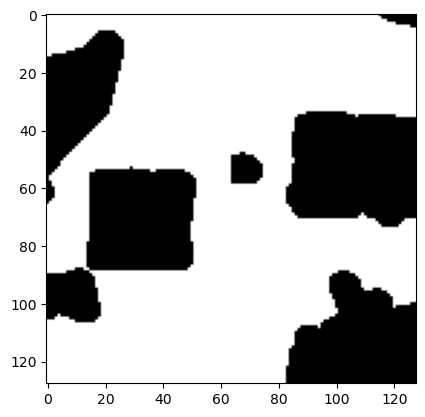

In [6]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread(r"C:\Users\sachi\Planning\Deep-RRT-Star-Implementation\images\0.jpg")

gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


height, width= gray_image.shape

total_pixels = height * width

print("Total number of pixels:", total_pixels)
# print(height , width)
# print(gray_image.shape)

for i in range(len(gray_image)):
    for j in range(len(gray_image[0])):
        if gray_image[i][j] > 200:
            gray_image[i][j] = 1
        else:
            gray_image[i][j] = 0

black_pixel_count = 0
white_pixel_count = 0
for i in range(len(gray_image)):
    for j in range(len(gray_image[0])):
        if gray_image[i][j] == 1:
            white_pixel_count += 1
        else:
            black_pixel_count += 1

print("Black pixel count:", black_pixel_count)
print("White pixel count:", white_pixel_count)
plt.imshow(gray_image , cmap = 'gray')
# print(gray_image)

In [1]:
import os
import cv2
import numpy as np
import random
import csv
import os

# Set the path to the images folder
images_folder = r"C:\Users\sachi\Planning\Deep-RRT-Star-Implementation\images"

# Set the number of images to load
n = 200

# Set the number of random start and goal points to generate
m = 200

# Create a list to store the image paths
image_paths = []

# Get the list of image file names in the images folder
for filename in os.listdir(images_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_paths.append(os.path.join(images_folder, filename))
        

# Randomly select n images from the image paths
selected_images = random.sample(image_paths, n)

# Create a list to store the start and goal points
points = []

def get_random_point(img):
    # Generate random x and y coordinates
    start_x = random.randint(0, width - 1)
    start_y = random.randint(0, height - 1)
    goal_x = random.randint(0, width - 1)
    goal_y = random.randint(0, height - 1)
    return start_x, start_y, goal_x, goal_y

# Iterate over the selected images
for i, image_path in enumerate(selected_images):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # print("image_path", image_path)
    # Get the height and width of the image
    height, width = img.shape

    # Generate m random start and goal points
    for _ in range(m):

        # Get random start and goal points
        start_x, start_y, goal_x, goal_y = get_random_point(img)
        # print("1", img[start_y, start_x], "2", img[goal_y, goal_x])

        # Continue sampling until both start and goal points are white (255)
        while img[start_y, start_x] != 255 or img[goal_y, goal_x] != 255:
            start_x, start_y, goal_x, goal_y = get_random_point(img)
            # print("3", img[start_y, start_x], "4", img[goal_y, goal_x])

        file_name = os.path.basename(image_path)

        # print(file_name)
        
        # Append the start and goal points to the list
        points.append([start_x, start_y, goal_x, goal_y, file_name[:-4]])

# Set the path to the CSV file
csv_file = r"C:\Users\sachi\Planning\Deep-RRT-Star-Implementation\start_goal_points_images.csv"

# Write the start and goal points to the CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['startx', 'starty', 'goalx', 'goaly', 'imagenumber'])
    writer.writerows(points)
    print("writing")

print(f"Successfully generated {m} start and goal points for {n} images and saved them to {csv_file}.")


writing
Successfully generated 200 start and goal points for 200 images and saved them to C:\Users\sachi\Planning\Deep-RRT-Star-Implementation\start_goal_points_images.csv.


Extract Files in series and write random start and goal points for each image

In [2]:
import os
import cv2
import numpy as np
import csv
import random

# Set the path to the images folder
images_folder = r"C:\Users\sachi\Planning\Deep-RRT-Star-Implementation\images"

# Set the number of random start and goal points to generate
m = 200

# Create a list to store the start and goal points
points = []

def get_random_point(img):
    # Generate random x and y coordinates
    start_x = random.randint(0, width - 10)
    start_y = random.randint(0, height - 10)
    goal_x = random.randint(0, width - 10)
    goal_y = random.randint(0, height - 10)
    return start_x, start_y, goal_x, goal_y

# Get the list of image file names in the images folder
image_paths = [os.path.join(images_folder, filename) for filename in os.listdir(images_folder) if filename.endswith('.jpg') or filename.endswith('.png')]

# Iterate over the image paths
for image_path in image_paths:
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Get the height and width of the image
    height, width = img.shape

    # Generate m random start and goal points
    for _ in range(m):

        # Get random start and goal points
        start_x, start_y, goal_x, goal_y = get_random_point(img)

        # Continue sampling until both start and goal points are white (255)
        while img[start_y, start_x] != 255 or img[goal_y, goal_x] != 255:
            start_x, start_y, goal_x, goal_y = get_random_point(img)

        file_name = os.path.basename(image_path)

        # Append the start and goal points to the list
        points.append([start_x, start_y, goal_x, goal_y, file_name[:-4]])

# Set the path to the CSV file
csv_file = r"C:\Users\sachi\Planning\Deep-RRT-Star-Implementation\start_goal_points_images.csv"

# Write the start and goal points to the CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['startx', 'starty', 'goalx', 'goaly', 'imagenumber'])
    writer.writerows(points)
    print("writing")

print(f"Successfully generated {m} start and goal points for each image and saved them to {csv_file}.")


writing
Successfully generated 200 start and goal points for each image and saved them to C:\Users\sachi\Planning\Deep-RRT-Star-Implementation\start_goal_points_images.csv.


In [ ]:
import csv

def process_csv_file(csv_file):
    # Read the CSV file
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Skip the header row
        data = list(reader)
    
    # Extract the data from the CSV file
    start_x_list = [int(row[0]) for row in data]
    start_y_list = [int(row[1]) for row in data]
    goal_x_list = [int(row[2]) for row in data]
    goal_y_list = [int(row[3]) for row in data]
    image_number_list = [int(row[4]) for row in data]
    
    # Call the RRTStar function for each data point
    paths = []
    for i in range(len(data)):
        start_x = start_x_list[i]
        start_y = start_y_list[i]
        goal_x = goal_x_list[i]
        goal_y = goal_y_list[i]
        image_number = image_number_list[i]
        
        # Call the RRTStar function
        path = RRTStar(start_x, start_y, goal_x, goal_y, image_number)
        paths.append(path)
    
    # Write the output to a new CSV file
    output_file = "output.csv"
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['current_x', 'current_y', 'goal_x', 'goal_y', 'image_number', 'next_node_x', 'next_node_y'])
        for i in range(len(data)):
            for j in range(len(paths[i])):
                current_x, current_y = paths[i][j]
                if j < len(paths[i]) - 1:
                    next_node_x, next_node_y = paths[i][j+1]
                else:
                    next_node_x, next_node_y = goal_x_list[i], goal_y_list[i]
                writer.writerow([current_x, current_y, goal_x_list[i], goal_y_list[i], image_number_list[i], next_node_x, next_node_y])
    
    print(f"Output written to {output_file}")

# Set the path to the CSV file
csv_file = r"C:\Users\sachi\Planning\Deep-RRT-Star-Implementation\path_images.csv"

# Process the CSV file
process_csv_file(csv_file)

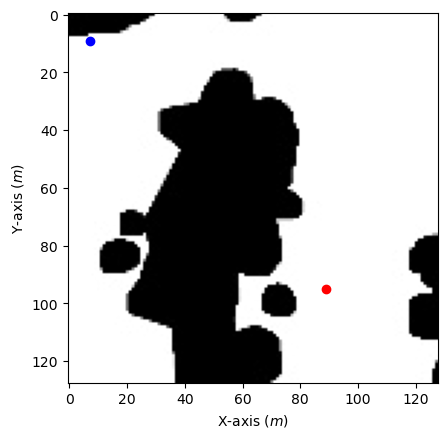

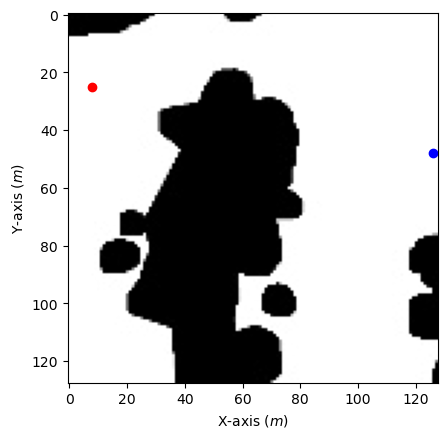

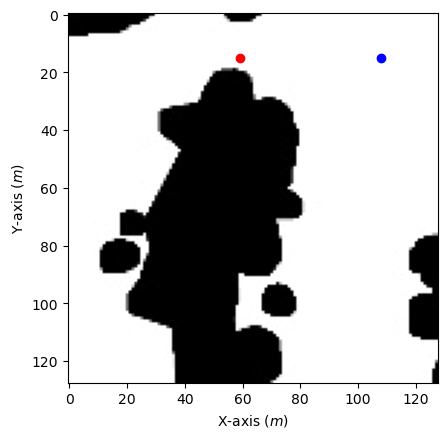

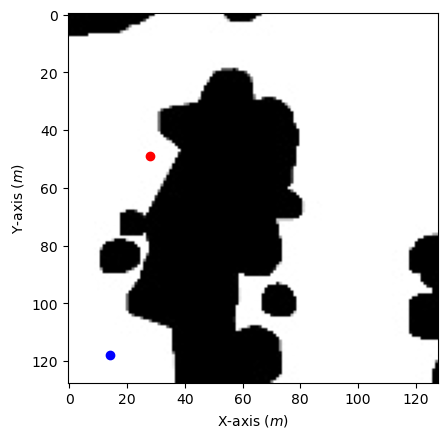

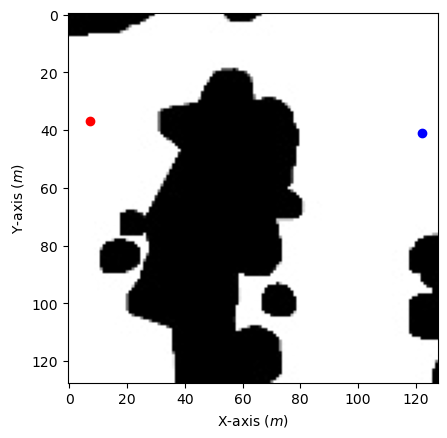

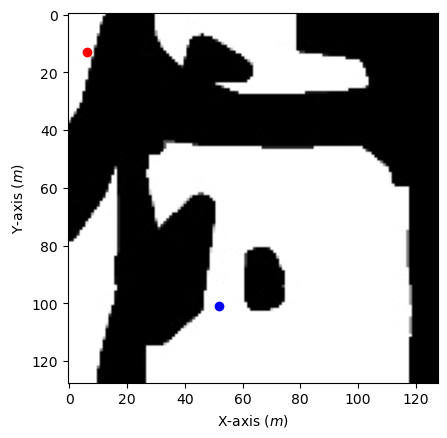

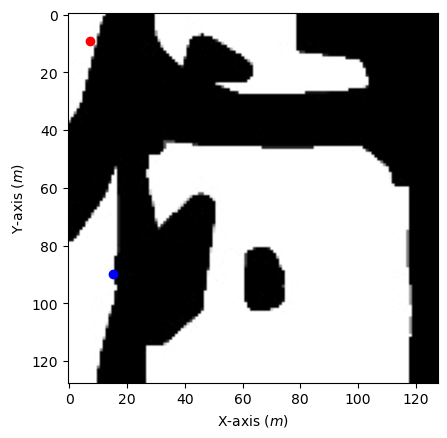

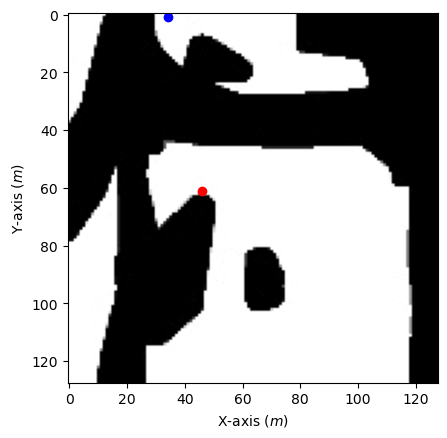

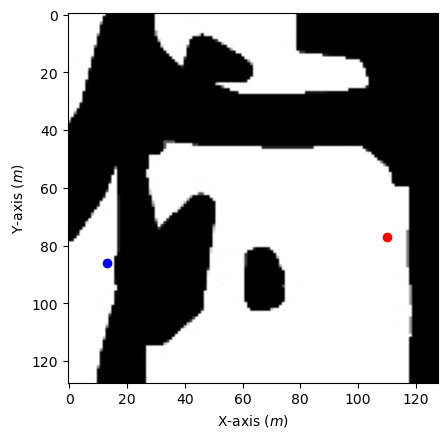

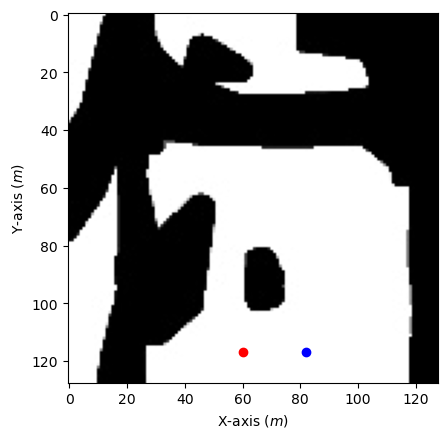

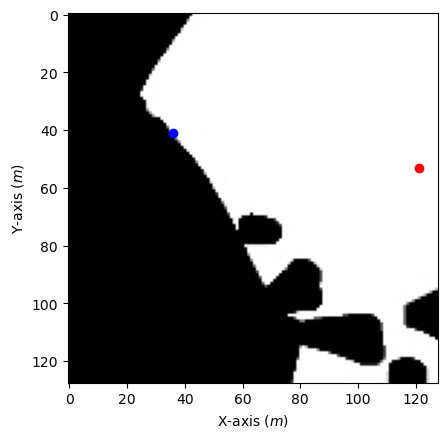

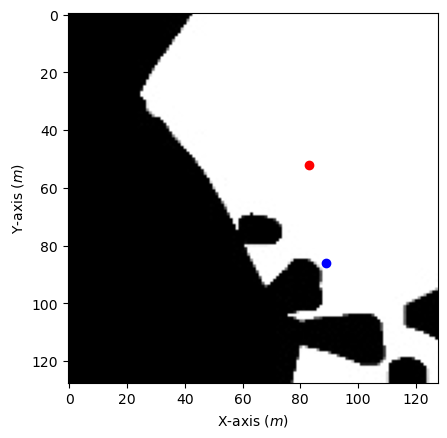

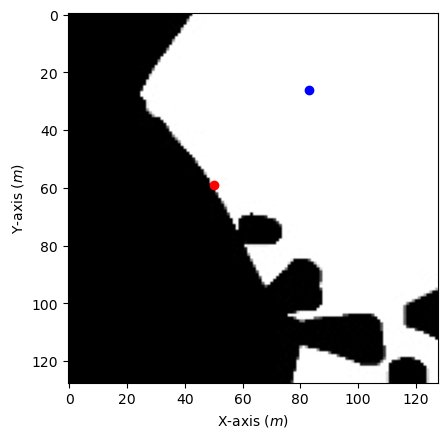

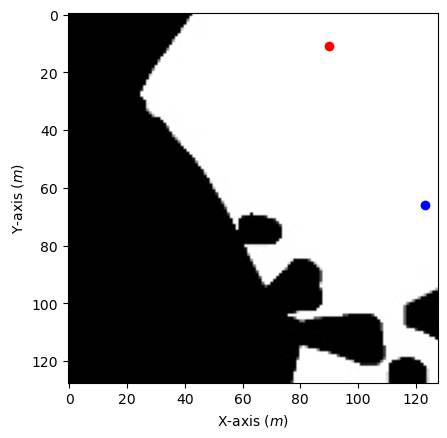

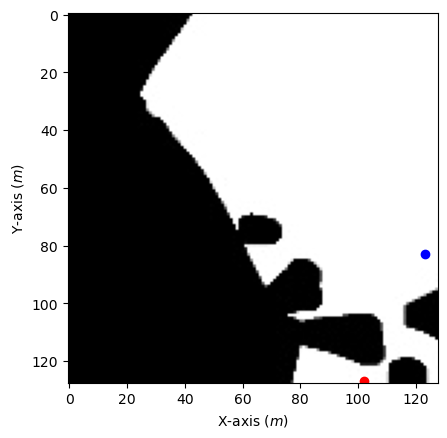

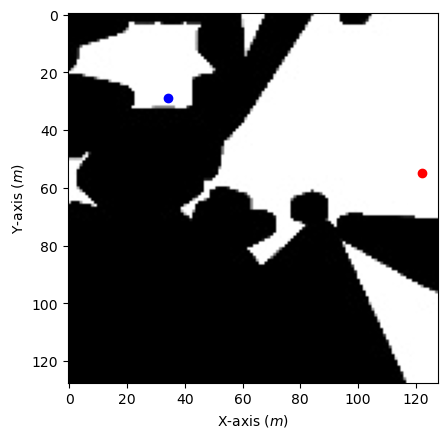

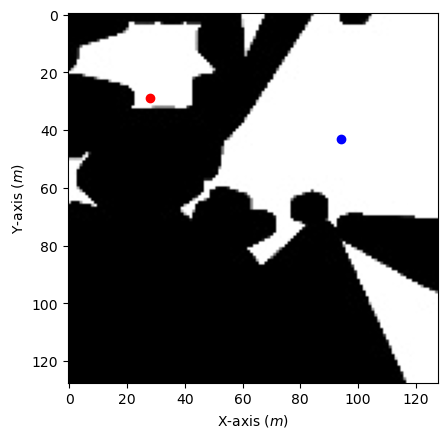

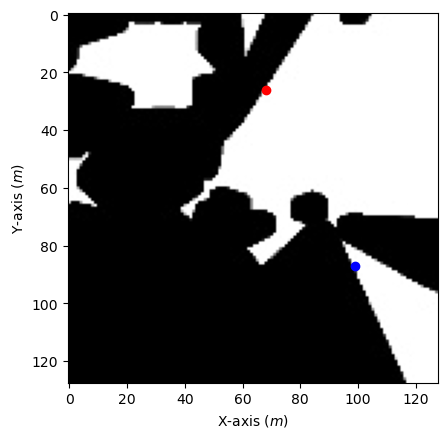

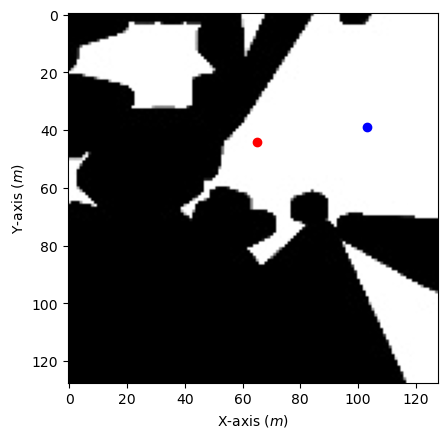

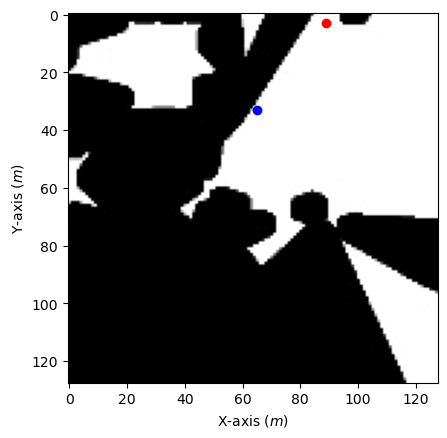

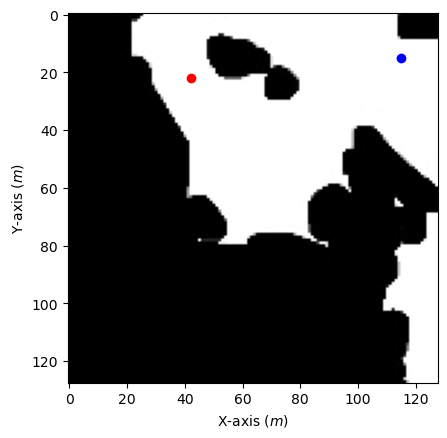

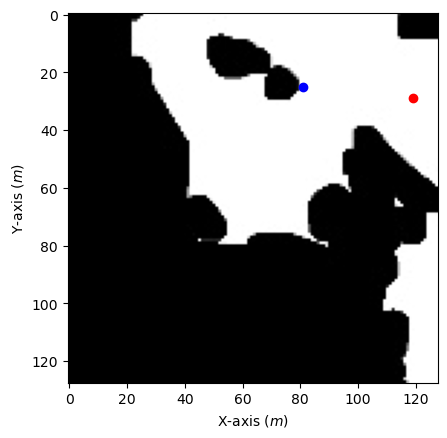

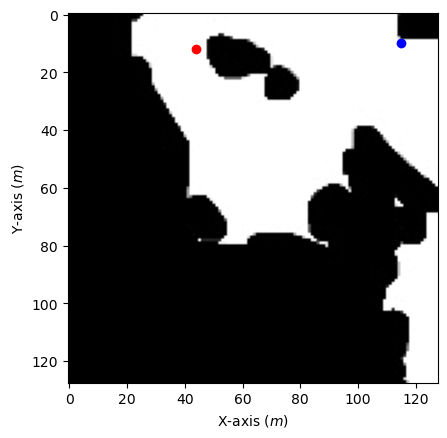

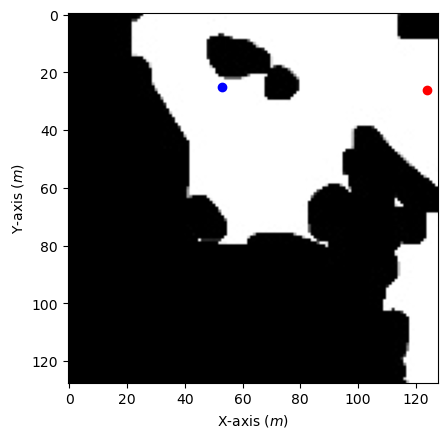

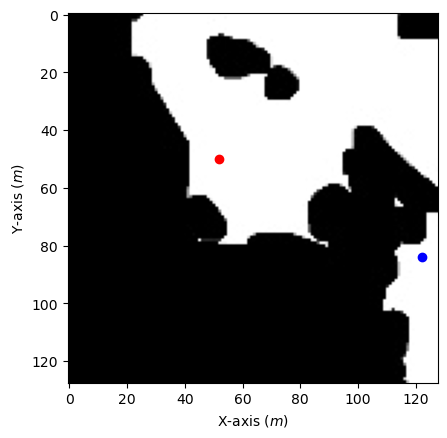

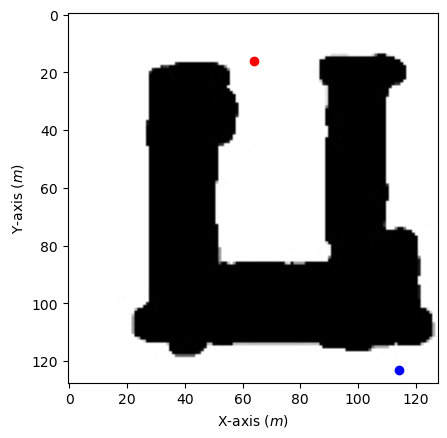

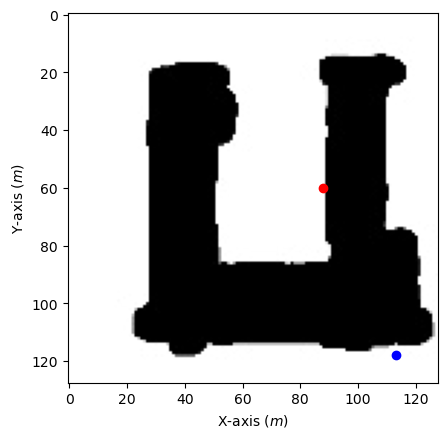

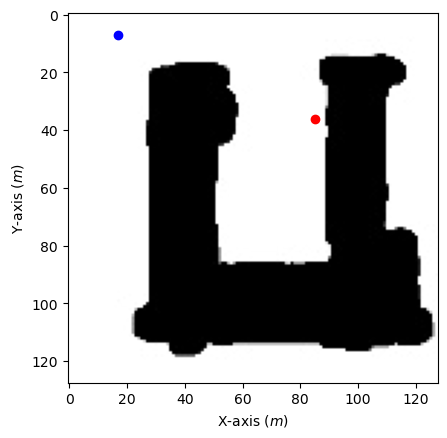

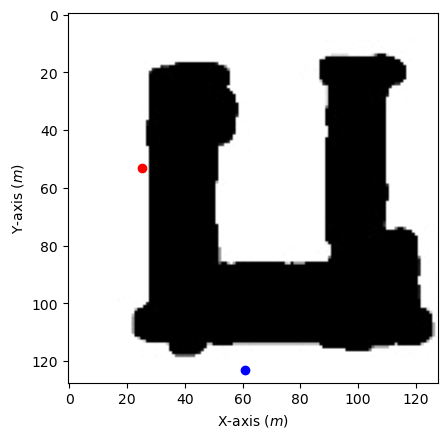

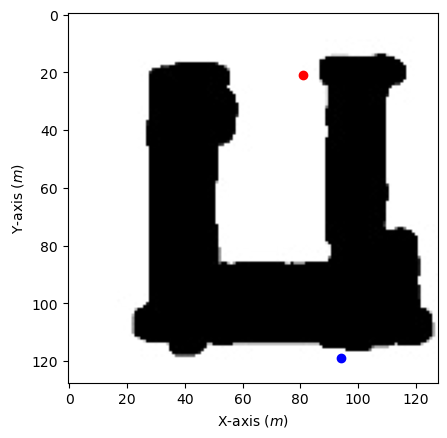

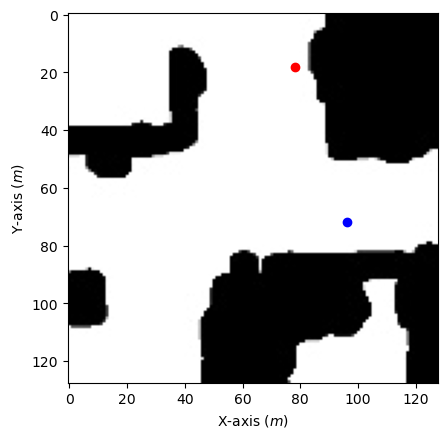

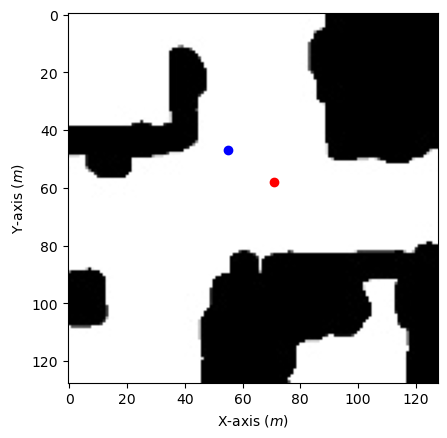

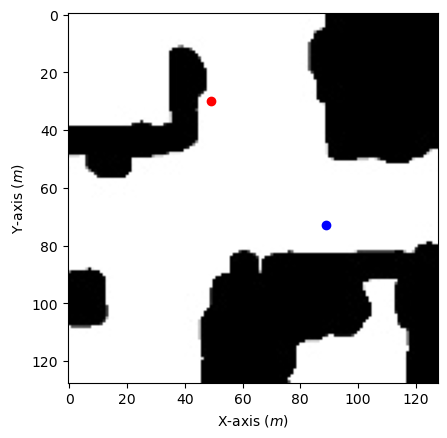

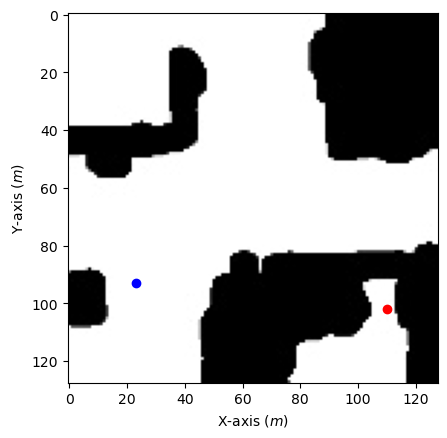

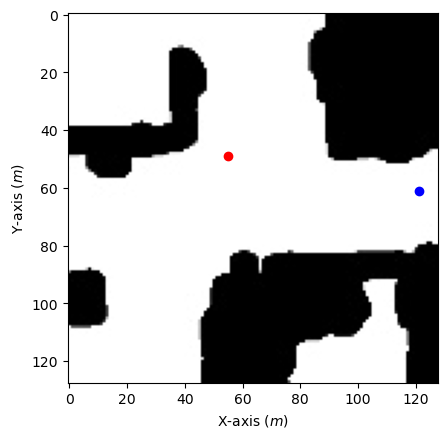

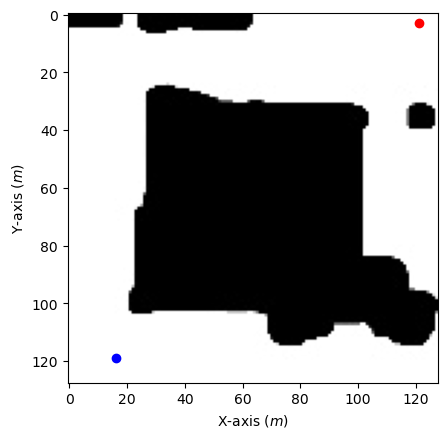

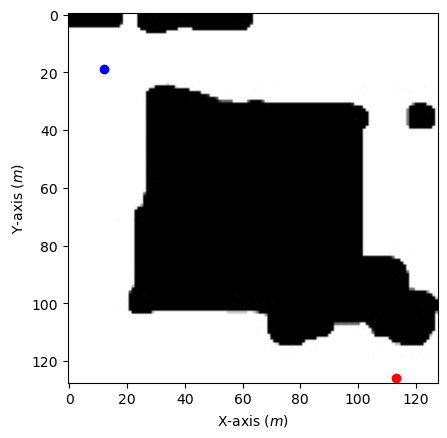

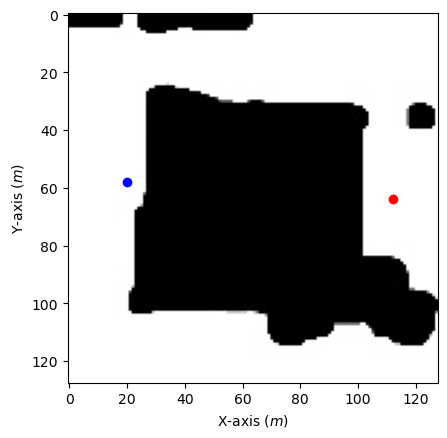

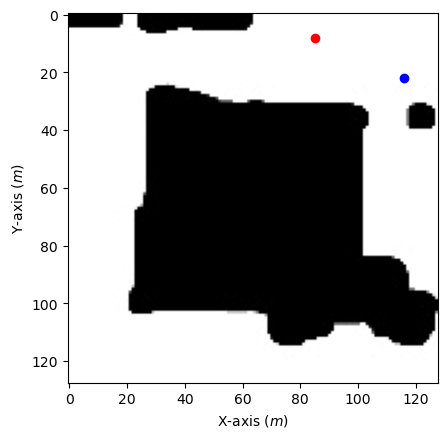

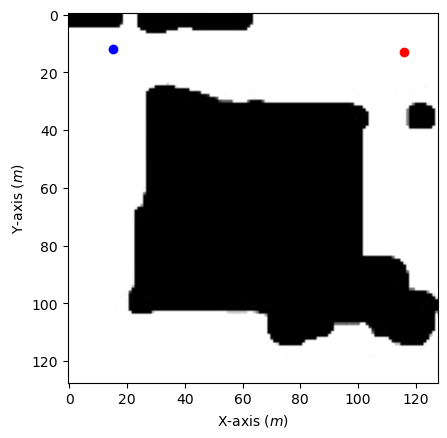

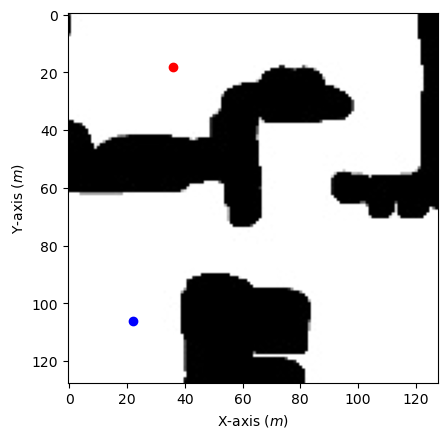

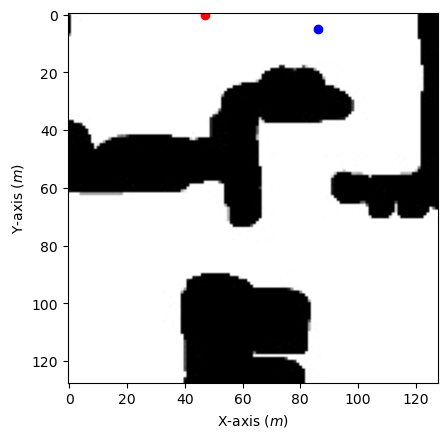

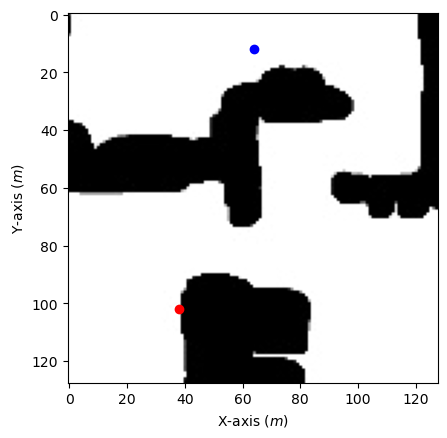

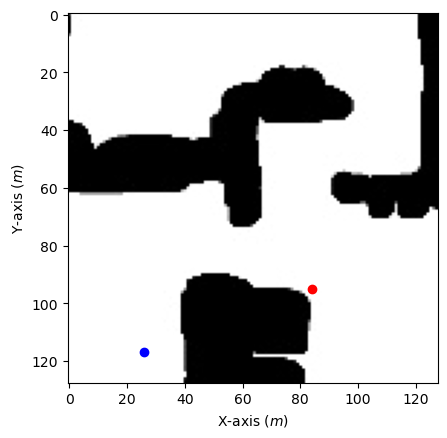

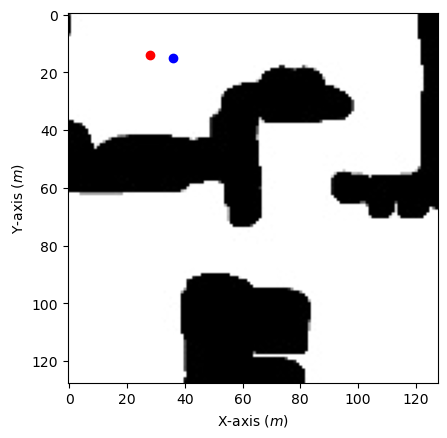

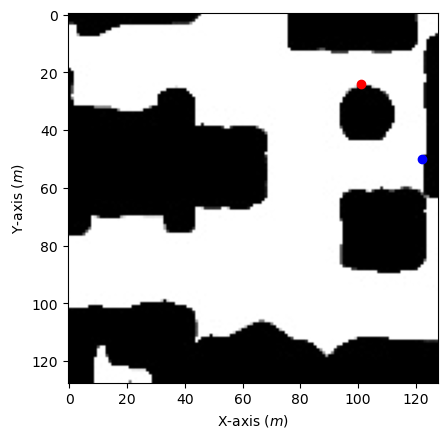

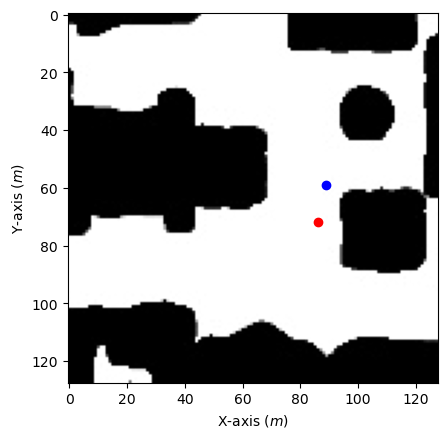

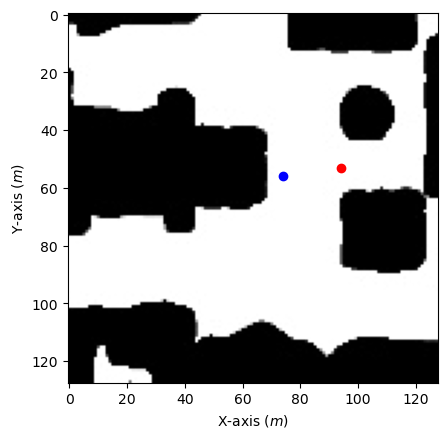

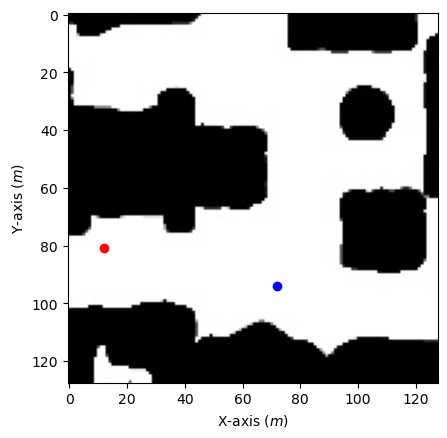

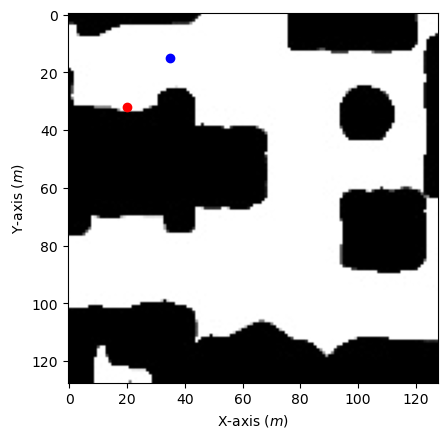

In [5]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import cv2

'''
Jpg Implementation
'''
file_path = r'C:\Users\sachi\Planning\Deep-RRT-Star-Implementation\start_goal_points_images.csv'

# Read the CSV file
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        start_x, start_y, goal_x, goal_y, image_number = map(int, row)
          
        image_path = cv2.imread(f'C:/Users/sachi/Planning/Deep-RRT-Star-Implementation/images/{image_number}.jpg')

        gray_image = cv2.cvtColor(image_path, cv2.COLOR_BGR2GRAY) 

        # Display the image
        fig = plt.figure("RRT Star Algorithm")
        numIterations = 700
        stepSize = 5

        # goalRegion = plt.Circle((goal_x, goal_y), stepSize, color='b', fill = False)
        plt.imshow(gray_image , cmap = 'gray')

        # plt.imshow(image, cmap='gray')
        plt.plot(start_x,start_y,'ro')
        plt.plot(goal_x,goal_y,'bo')
        ax = fig.gca()
        
        # ax.add_patch(goalRegion)
        plt.xlabel('X-axis $(m)$')
        plt.ylabel('Y-axis $(m)$')
        plt.show()